In [ ]:
1+1

In [ ]:
import numpy as np
import pandas as pd
from itertools import product

# Function to calculate Sharpe ratio
def sharpe_ratio(pnl_net):
    return pnl_net.mean() / pnl_net.std() * np.sqrt(255)

# Function to compute PnL and Net PnL
def compute_pnl(W, tba_prices, bid_ask):
    pnl = (W.shift(1) * tba_prices.diff()).sum(axis=1)
    transaction_cost = (W.diff().abs() * bid_ask).sum(axis=1)
    pnl_net = pnl - transaction_cost
    return pnl, pnl_net

# Define all strategy methods
def method_1(oas, params):
    """Threshold-based filtering: Only trade if OAS deviation is large."""
    threshold = params['threshold']
    
    median_oas = oas.median(axis=1)
    mask = (oas.sub(median_oas, axis=0).abs() > threshold)
    W = np.where(mask, assign_weights(oas), 0)
    return pd.DataFrame(W, index=oas.index, columns=oas.columns)


def method_2(oas, params):
    """Momentum-based weighting: Adjust weights based on trend."""
    momentum_window = params['momentum_window']
    
    momentum = oas.diff(momentum_window).rank(axis=1)
    W = assign_weights(oas) * (momentum / momentum.abs().sum(axis=1).values[:, None])
    return W


def method_3(oas, params):
    """Risk-adjusted weighting: Scale weights by OAS volatility."""
    risk_window = params['risk_window']
    
    oas_vol = oas.rolling(risk_window).std()
    W = assign_weights(oas) / oas_vol
    return W.div(W.abs().sum(axis=1), axis=0)


def method_4(oas, params):
    """Adaptive holding period: Change positions only if ranking shifts persist."""
    holding_period = params['holding_period']
    
    W = assign_weights(oas)
    W = W.rolling(holding_period).mean()
    return W


def method_5(oas, params):
    """Market impact aware: Reduce trading when bid-ask spreads widen."""
    spread_sensitivity = params['spread_sensitivity']
    
    W = assign_weights(oas)
    market_condition = (bid_ask.rolling(5).mean() > spread_sensitivity)
    W[market_condition] *= 0.5  # Reduce exposure when bid-ask is high
    return W


def method_6(oas, params):
    """Rolling mean smoothing: Limit transaction costs by averaging past weights."""
    smoothing_window = params['smoothing_window']
    
    W = assign_weights(oas)
    W = W.rolling(smoothing_window).mean()
    return W


def method_7(oas, params):
    """Hybrid model: Combine OAS ranking and momentum confirmation."""
    momentum_window = params['momentum_window']
    
    momentum = oas.diff(momentum_window).rank(axis=1)
    W = assign_weights(oas)
    W[momentum < 0] = 0  # Filter trades against trend
    return W


# Strategy testing framework
def optimize_strategies(oas, tba_prices, bid_ask):
    methods = {
        'method_1': method_1,
        'method_2': method_2,
        'method_3': method_3,
        'method_4': method_4,
        'method_5': method_5,
        'method_6': method_6,
        'method_7': method_7,
    }
    
    # Parameter grid
    param_grid = {
        'method_1': [{'threshold': t} for t in [0.01, 0.02, 0.03]],
        'method_2': [{'momentum_window': w} for w in [5, 10, 20]],
        'method_3': [{'risk_window': w} for w in [10, 20, 30]],
        'method_4': [{'holding_period': h} for h in [3, 5, 7]],
        'method_5': [{'spread_sensitivity': s} for s in [0.02, 0.05, 0.1]],
        'method_6': [{'smoothing_window': w} for w in [3, 5, 10]],
        'method_7': [{'momentum_window': w} for w in [5, 10, 20]],
    }
    
    results = []  # Store results
    pnl_net_storage = {}  # Store pnl_net for each method & param set
    
    for method, param_list in param_grid.items():
        for params in param_list:
            W = methods[method](oas, params)  # Get weights
            pnl, pnl_net = compute_pnl(W, tba_prices, bid_ask)  # Compute PnL
            sharpe = sharpe_ratio(pnl_net)  # Compute Sharpe ratio
            
            results.append({'method': method, 'params': params, 'sharpe_ratio': sharpe})
            pnl_net_storage[(method, str(params))] = pnl_net
    
    # Convert results to DataFrame for easy analysis
    results_df = pd.DataFrame(results)
    return results_df, pnl_net_storage

# Run optimization
# results_df, pnl_net_storage = optimize_strategies(oas_residuals, tba_prices, bid_ask)
# results_df.to_csv('strategy_results.csv')  # Save results
# print(results_df.sort_values(by='sharpe_ratio', ascending=False))


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # type: ignore
import plotly.express as px # type: ignore
from sklearn.decomposition import PCA

sns.set_theme(rc={'figure.figsize':(5,3)})

In [2]:
def get_data(sub_folder, ALL_CPNS, oas_bloom_filter=False):


    OAS = pd.read_csv(f'Data/{sub_folder}/OAS.csv', index_col=0, parse_dates=True, dayfirst=False)
    OAS.columns = OAS.columns.map(float)
    OAS = OAS[ALL_CPNS]

    if oas_bloom_filter :

        OAS_BLOOM = pd.read_csv("Data/OAS_vs_TREAS.csv", index_col=0, parse_dates=True)
        OAS_BLOOM.columns = OAS_BLOOM.columns.map(float)
        OAS_BLOOM = OAS_BLOOM[ALL_CPNS]

        OAS = OAS.where(OAS_BLOOM.notna())
        OAS.dropna(how='all', inplace=True)
    

    TBAS_PRICES = pd.read_csv("Data/GENERIC_TBAS.csv", index_col=0, parse_dates=True).dropna(how="all")
    TBAS_PRICES.columns = TBAS_PRICES.columns.map(lambda x: float(x.split()[1]))
    TBAS_PRICES = TBAS_PRICES[ALL_CPNS]
    TBAS_PRICES = TBAS_PRICES.loc[OAS.index]

    Durations = pd.read_csv(f'Data/{sub_folder}/Durations.csv', index_col=0, parse_dates=True)
    Durations.columns = Durations.columns.map(float) 
    Durations = Durations[ALL_CPNS]
    Durations = Durations.loc[OAS.index]

    return TBAS_PRICES, OAS, Durations

In [3]:
ALL_CPNS = np.arange(2.5, 7, 0.5)
TBAS_PRICES, OAS, Durations = get_data('DATA_SAMY', ALL_CPNS, oas_bloom_filter=False)

In [6]:
OAS = OAS.dropna()
TBAS_PRICES = TBAS_PRICES.loc[OAS.index]
Durations = Durations.loc[OAS.index]


OAS.to_csv('OAS.csv')
TBAS_PRICES.to_csv('TBAS_PRICES.csv')
Durations.to_csv('Durations.csv')

<Axes: xlabel='Dates'>

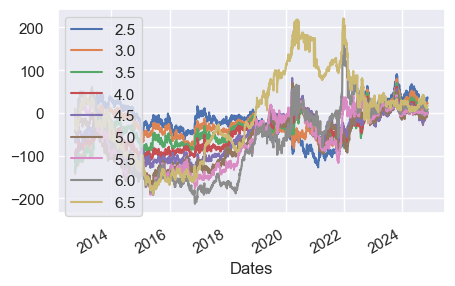

In [10]:
OAS.plot()